In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

import pickle, time

# pd.set_option("display.max_columns", 100)

In [2]:
df = pd.read_pickle("../../data/total_dataset.pkl") # total dataset
#df = df.drop(["accept_kaon", "accept_muon", "accept_pion", "dilepton_mass"], axis = 1) # signal and background should have the same columns
print("Total dataset number of events: ", len(df))

signal = pd.read_csv("../../data/csv/sig.csv") # as a signal, simulated data is used
print("Number of simulated signal events: ", len(signal))

bg = pd.read_pickle("../../data/pKmumu_piTop.pkl")
print("Number of background events: ", len(bg))

# labels for decision trees (0 - background; 1 - signal)
vals = np.concatenate([np.zeros(len(bg)), np.ones(len(signal))])
print("Length of labels array", len(vals))

# (X - independent; Y - dependent) variables for the decision tree classifier
X = bg.append(signal) # concatenation of the two dataframes
X = X.drop(["year", "polarity", "Unnamed: 0"], axis = 1) # dropping columns that have not effect, but may have NaN or other inappropriate data
Y = vals

Total dataset number of events:  498357
Number of simulated signal events:  8802
Number of background events:  68153
Length of labels array 76955


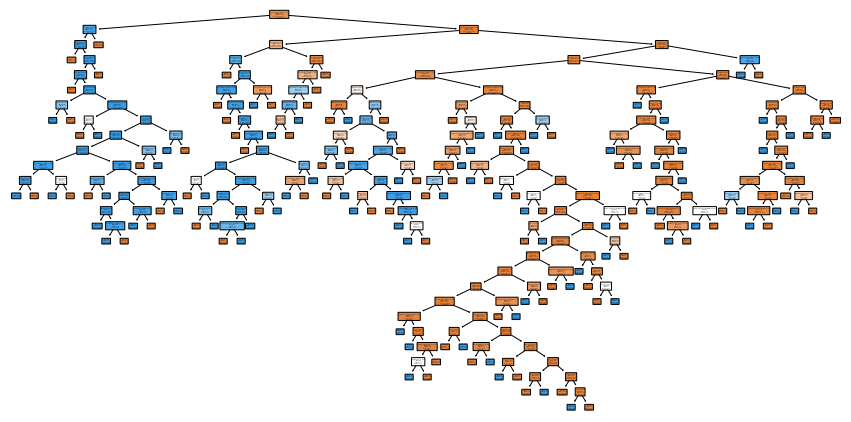

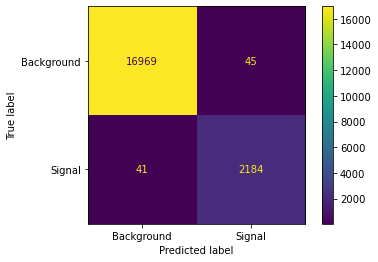

In [3]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y) # splitting data into test and train samples
clf_dt = DecisionTreeClassifier() # creating a Decision Tree
clf_dt = clf_dt.fit(X_train, Y_train) # training it

# Plotting a resulting decision tree
plt.figure(figsize = (15, 7.5))
plot_tree(clf_dt,
         filled = True,
         rounded = True,
         class_names = ["Bg", "Sig"],
         feature_names = X.columns)

# Plotting a confusion matrix, which will check on the test data false-positive and false-negative identifications
plot_confusion_matrix(clf_dt, X_test, Y_test, display_labels = ["Background", "Signal"])

<h3>Next section investigates overfitting prevention</h3>

<h3>End of investigation</h3>

In [4]:
path = clf_dt.cost_complexity_pruning_path(X_train, Y_train)
ccp_alphas = path.ccp_alphas
ccp_alphas = ccp_alphas[:-1] # last one should be removed

print(ccp_alphas)
print(len(ccp_alphas))

[0.00000000e+00 1.67486774e-05 1.71223802e-05 1.71247504e-05
 1.71529559e-05 1.72385643e-05 1.72810977e-05 1.73096696e-05
 1.73143161e-05 1.73258374e-05 1.73262180e-05 1.73262180e-05
 1.73262180e-05 1.73262180e-05 1.96788295e-05 2.31016240e-05
 2.31016240e-05 2.31016240e-05 2.31016240e-05 2.31016240e-05
 2.31016240e-05 2.59893270e-05 2.66999411e-05 2.77219489e-05
 2.82308200e-05 2.88770301e-05 3.34483706e-05 3.34589539e-05
 3.39008589e-05 3.41300434e-05 3.41428414e-05 3.44791081e-05
 4.02292942e-05 4.06588583e-05 4.12448346e-05 4.15829233e-05
 4.45034865e-05 4.69974635e-05 5.19786541e-05 5.43144850e-05
 5.58884650e-05 5.61901934e-05 5.77540601e-05 5.98750991e-05
 6.37604824e-05 6.78931062e-05 7.27701157e-05 9.78698399e-05
 1.07888637e-04 1.13792653e-04 1.31251774e-04 1.50442508e-04
 4.00875786e-04 7.37292486e-04 7.63295636e-04 1.40307852e-03
 1.44201999e-03 5.93954258e-03 1.64139829e-02]
59


Starting alpha num:  0
Execution time for alpha:  21.646344423294067
Starting alpha num:  1
Execution time for alpha:  21.675743341445923
Starting alpha num:  2
Execution time for alpha:  21.4302499294281
Starting alpha num:  3
Execution time for alpha:  21.252686500549316
Starting alpha num:  4
Execution time for alpha:  21.561434745788574
Starting alpha num:  5
Execution time for alpha:  21.309569358825684
Starting alpha num:  6
Execution time for alpha:  21.2055184841156
Starting alpha num:  7
Execution time for alpha:  21.495209217071533
Starting alpha num:  8
Execution time for alpha:  21.49325180053711
Starting alpha num:  9
Execution time for alpha:  21.161704778671265
Starting alpha num:  10
Execution time for alpha:  21.504830598831177
Starting alpha num:  11
Execution time for alpha:  21.372490882873535
Starting alpha num:  12
Execution time for alpha:  21.216284036636353
Starting alpha num:  13
Execution time for alpha:  21.45029377937317
Starting alpha num:  14
Execution ti

<AxesSubplot:xlabel='alpha'>

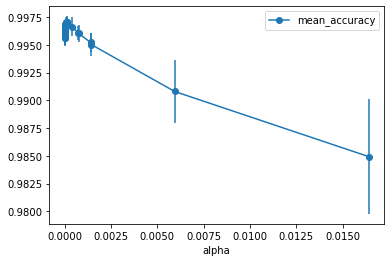

In [5]:
alpha_loop_values = []
# Check different alpha values with cross validation providing errorbars
init_time = time.time()
for num, ccp_alpha in enumerate(ccp_alphas): # not all alphas are used to save some time - for better precision all ccp_alphas should be looked at
    print("Starting alpha num: ", num)
    start_time = time.time()
    clf_dt = DecisionTreeClassifier(ccp_alpha = ccp_alpha)
    scores = cross_val_score(clf_dt, X_train, Y_train, cv = 5)
    alpha_loop_values.append([ccp_alpha, np.mean(scores), np.std(scores)])
    print("Execution time for alpha: ", time.time() - start_time)
print("Total execution time: ", time.time() - init_time)
    
alpha_results = pd.DataFrame(alpha_loop_values, columns = ["alpha", "mean_accuracy", "std"])

alpha_results.plot(x = 'alpha', y = 'mean_accuracy', yerr = 'std', marker = 'o')

<AxesSubplot:xlabel='alpha'>

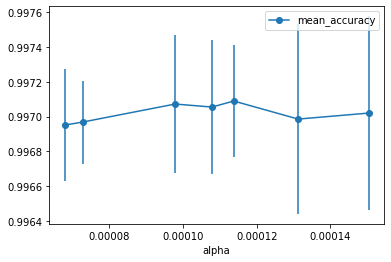

In [12]:
# find the best alpha in terms of absolute accuracy and its error
alpha_results[45:-7].plot(x = 'alpha', y = 'mean_accuracy', yerr = 'std', marker = 'o')


0.00011379265308885856


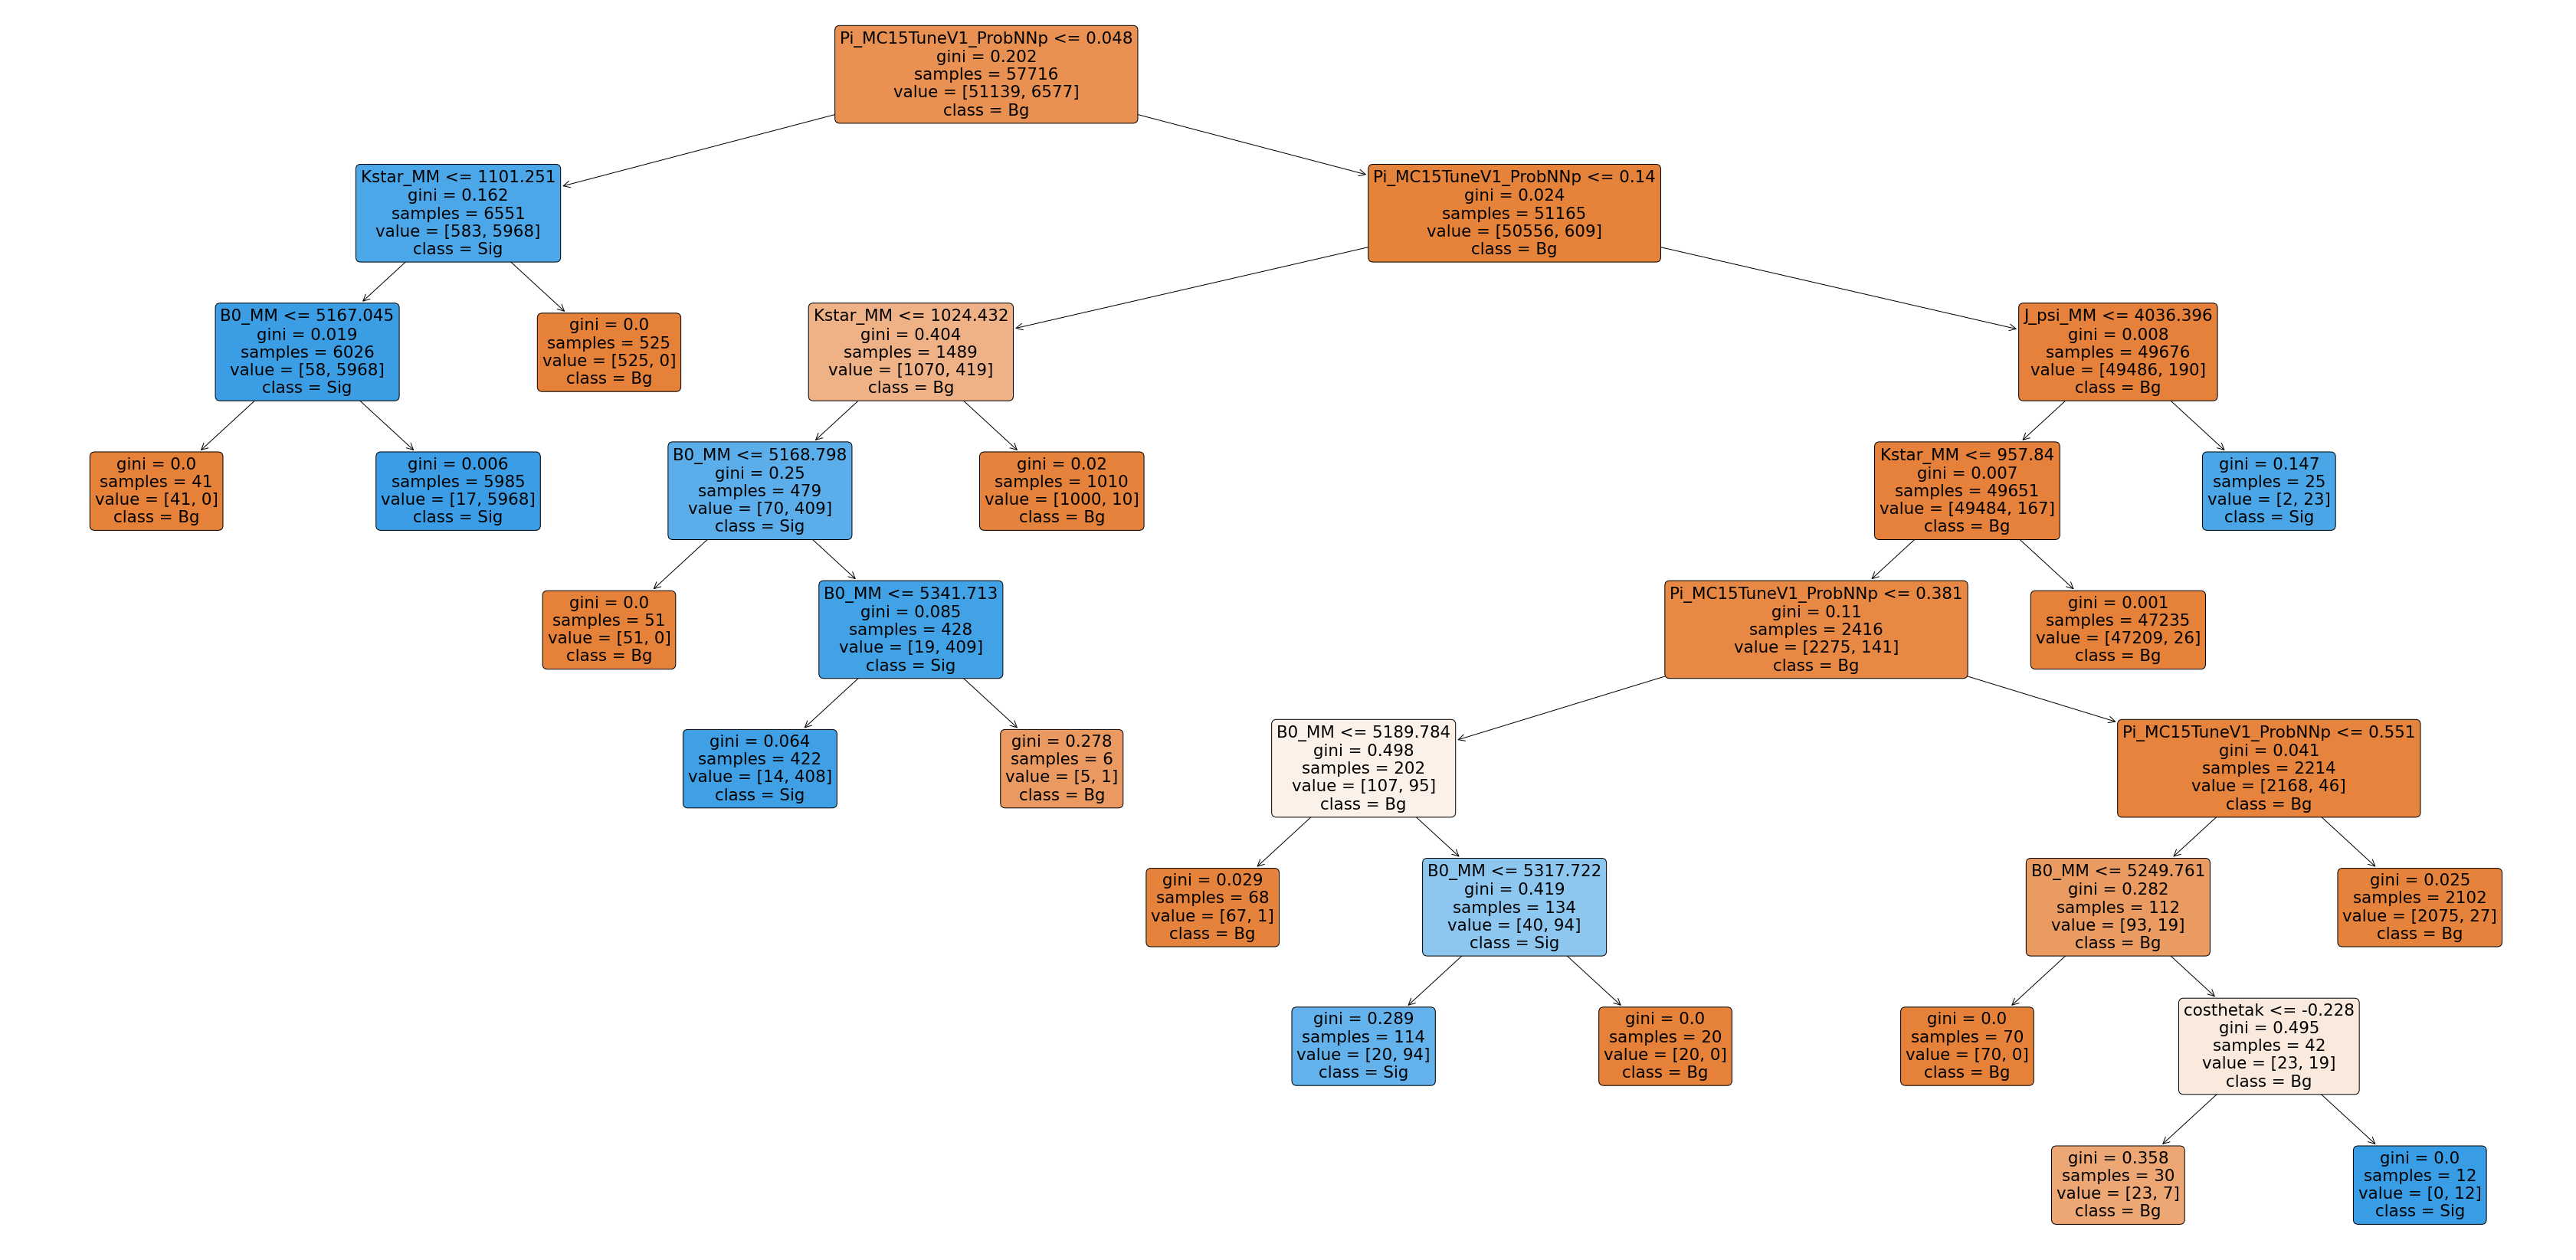

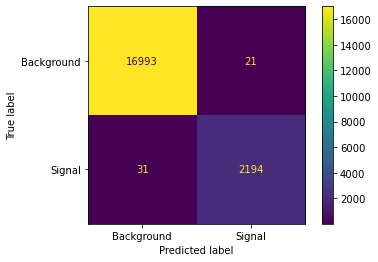

In [14]:
# Extract the best value of alpha
ideal_alpha = ccp_alphas[(ccp_alphas > 0.00011) & (ccp_alphas < 0.00012)][0]
ideal_alpha = float(ideal_alpha)
print(ideal_alpha)

# Resulting decision tree with the ccp_alpha being used to prevent overfitting
clf_dt = DecisionTreeClassifier(ccp_alpha = ideal_alpha)
clf_dt = clf_dt.fit(X_train, Y_train)

plt.figure(figsize = (60, 30))
plot_tree(clf_dt,
         filled = True,
         rounded = True,
         class_names = ["Bg", "Sig"],
         feature_names = X.columns)

# Corresponding confusion matrix
plot_confusion_matrix(clf_dt, X_test, Y_test, display_labels = ["Background", "Signal"])

In [15]:
with open("tree_pKmumu_piTop", 'wb') as f: # exporting decision tree to 'tree_jpsi' binary file
    pickle.dump(clf_dt, f)

Number of bg (0) and signal (1) events identified (array([0., 1.]), array([210949, 287408], dtype=int64))


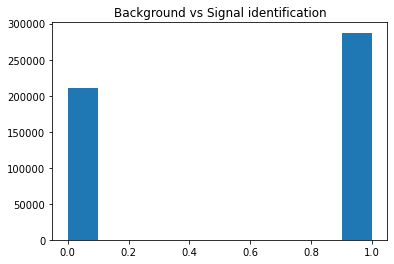

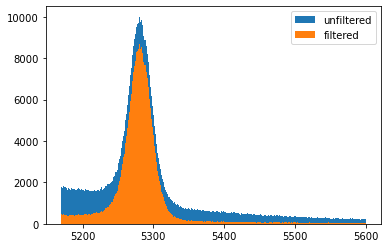

In [16]:
df = pd.read_pickle("../../data/total_dataset.pkl")
#df = df.drop(["accept_kaon", "accept_muon", "accept_pion", "dilepton_mass"], axis = 1)
#print("Total number of events:", len(df))
#total_data = df[(df["B0_MM"] > min_mass) & (df["B0_MM"] < max_mass)].drop(["year", "polarity", "Unnamed: 0"], axis = 1)
#print("Number of events in the mass region", len(total_data))

# Passing data to decision tree
result = clf_dt.predict(df.drop(["year", "polarity"], axis = 1))

print("Number of bg (0) and signal (1) events identified", np.unique(result, return_counts = True))
plt.title("Background vs Signal identification")
plt.hist(result)
plt.show()

# Extracting signal data to 'Filtered_data.pkl'
df["Result"] = result
filtered = df[df["Result"] == 1]
filtered.to_pickle("Filtered_data.pkl")

# Histogram of the filtered data
plt.hist(df['B0_MM'], range=[5170, 5600], bins=300, zorder=1, label = "unfiltered")
plt.hist(filtered['B0_MM'], range=[5170, 5600], bins=300, zorder=2, label = "filtered")
plt.legend()
plt.show()